In [1]:
!pip install tabgan==1.3.3

import os
import pandas as pd
import numpy as np
from time import time

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 8)})
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML

# Statistics
from scipy.stats import norm
from scipy.stats import zscore
from scipy import stats

# Avoid verbosity
import warnings
warnings.filterwarnings('ignore')

# Classifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer


# Metrics
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score

In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets.values
  
# metadata 
#print(default_of_credit_card_clients.metadata) 
  
# variable information 
#print(default_of_credit_card_clients.variables) 

In [3]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
dtypes: int64(23

In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
X2,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
X3,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
X4,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
X5,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
X6,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
X7,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
X8,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
X9,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
X10,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


### KDE plot.

The first 5 features are categorical the others columns are our features.

In [6]:
#Amount of bill statement
bill_features = [f'X{i}' for i in range(12, 18)]
# Amount of previous payment
prev_payment = [f'X{i}' for i in range(18, 24)]

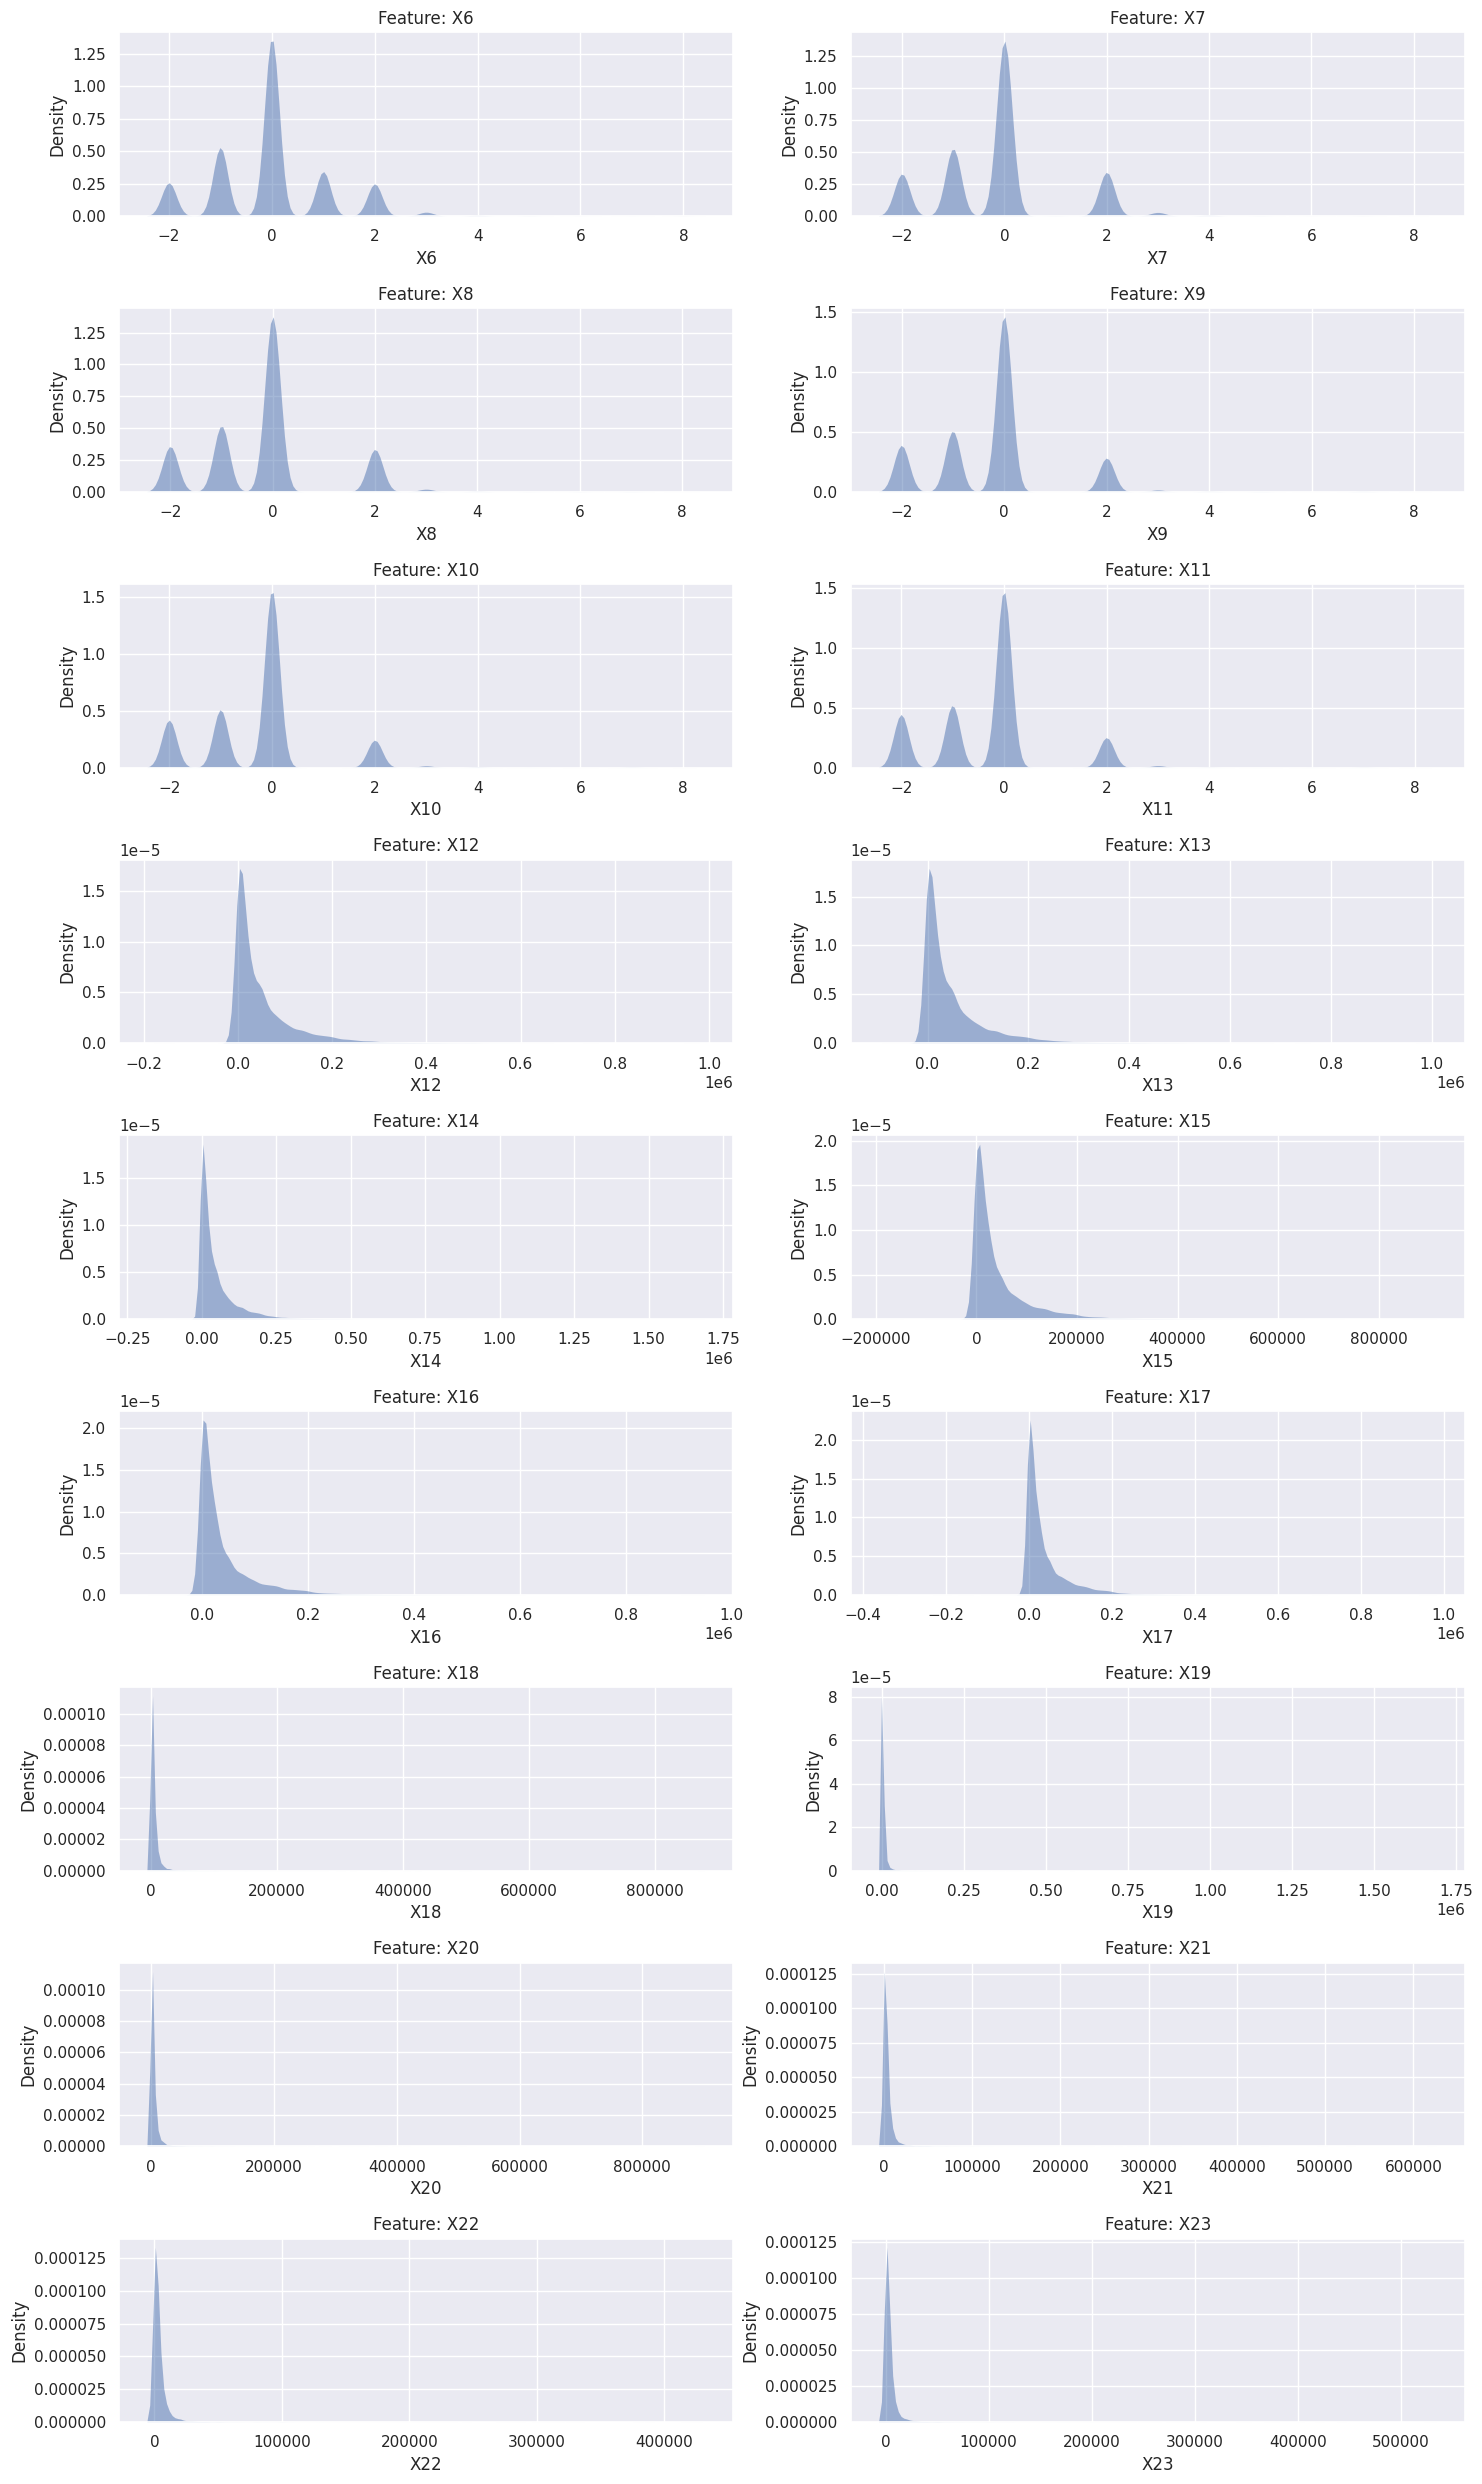

In [7]:
features = [f'X{i}' for i in range(6, 24)]
n = len(features)
rows = 2
cols = (n + 1) // 2  
fig, axs = plt.subplots(cols, 2, figsize=(15, 25))
axs = axs.flatten()

# Plot KDE plots for each dataset
for i, col in enumerate(features):
    
    sns.kdeplot(data=X, x=col, fill=True, common_norm=False, palette="spectral", alpha=.5, linewidth=0, ax=axs[i])
    ax=axs[i].set_title(f'Feature: {col}')
    
plt.tight_layout()
plt.show()

The average values by rows for bill_features increase the accuracy and also has a linear correlation with prev_payment mean. 

In [8]:
X['X18A'] = X[bill_features].mean(axis=1)
X['X23A'] = X[prev_payment].mean(axis=1)

### Correlation Plot.

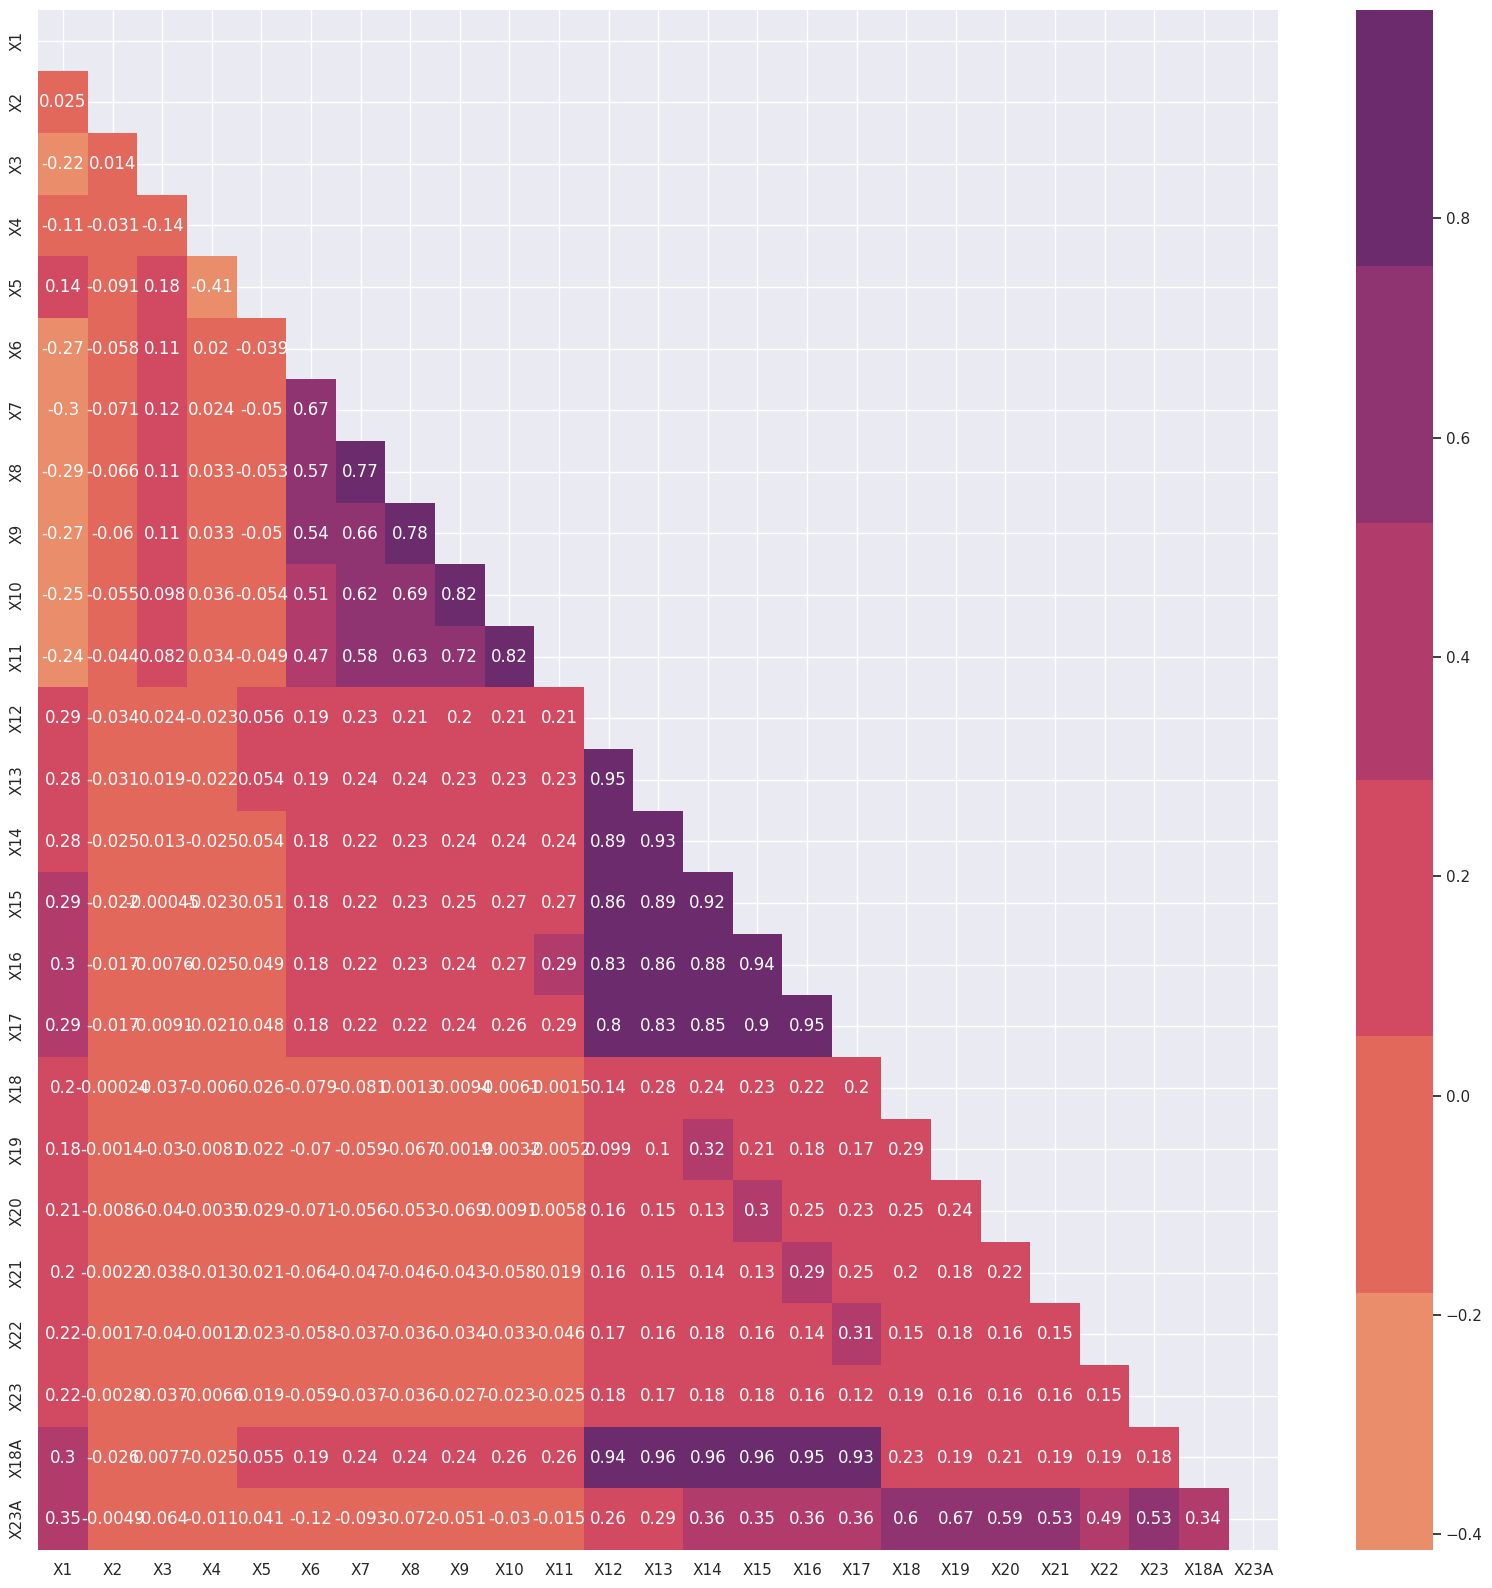

In [9]:
corr_numer = X.corr(method='pearson')

# Create an upper triangle to make it easier to plot
upp_triang = np.triu(corr_numer)

plt.figure(figsize=(20, 20))
fig = sns.heatmap(corr_numer, annot = True, fmt='.2g', mask = upp_triang, vmax=0.99, cmap=sns.color_palette("flare"))

plt.show()

### PCA.

The principal components can reveal hidden patterns in your data and by focusing on the main components, you filter out less important variations. It's really important to scale the data before starting PCA, MixMaxScaler or RobustScaler, as your choice is applicable.

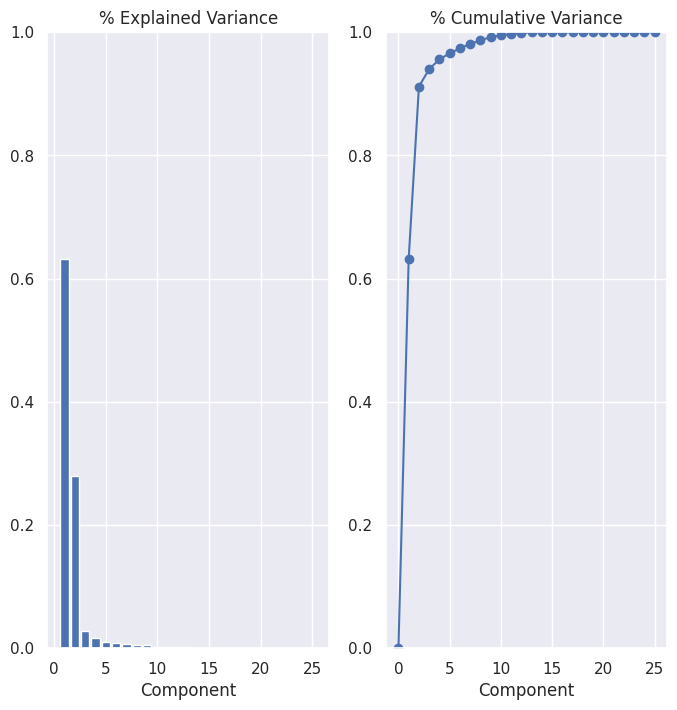

In [10]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T,  
    columns=component_names,  
    index=X.columns,  
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
kf = KFold(n_splits=10)

### Decision Tree and Random Forest.

I'll also try to use GridSearch for DT and RF model to see improvements using GridSearch. As a strategy I'll use the cross-validation Kfold.

### Decision Tree. 

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

tree_prediction = tree.predict(X_val)
roc_tree = accuracy_score(y_val, tree_prediction)
print(f'ROC: {roc_tree}')

ROC: 0.7310666666666666


In [13]:
tree_params = {
                'ccp_alpha': [0.1, .01, .001],
                'max_depth' : [5, 6, 7, 8, 9],
                'criterion' :['gini', 'entropy'],
                 'max_leaf_nodes':[i for i in range(4, 13)]}
    
gs_tree = GridSearchCV(estimator=tree, 
                       param_grid=tree_params,
                       cv=kf,
                       verbose=-1, 
                       scoring='roc_auc',
                       n_jobs=-1) 
gs_tree.fit(X_train, y_train)

print('Best parameters:', gs_tree.best_params_)

gs_tree.fit(X_train, y_train)

decisiontree = DecisionTreeClassifier(**gs_tree.best_params_)
decisiontree.fit(X_train, y_train)
tree_prediction = decisiontree.predict(X_val)

print('Accuracy', accuracy_score(y_val, tree_prediction))
# Best parameters: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 12}

Best parameters: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 12}
Accuracy 0.8196


### Random Forest. 

Runs quite slow, feel free to download the notebook and see what kind of differences would make, if performs better or worse then DT. GridSearch is generally slow for RF so it will take time to run.

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
forest_prediction = forest.predict(X_val)

print('Accuracy', accuracy_score(y_val, forest_prediction))

Accuracy 0.8130666666666667


GridSearch is quite slow. feel free to test which are the best parameters to improve the accuracy

In [15]:
# forest_params = {
#     'n_estimators': [10**i for i in range(10, 12)], 
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [i for i in range(1, 7, 2)],
#     'min_samples_split': [i for i in range(1, 7, 2)],
#     'min_samples_leaf': [2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# forest_gs = GridSearchCV(estimator=forest, 
#                        param_grid=forest_params,
#                        cv=kf,
#                        verbose=-1, 
#                        scoring='roc_auc',
#                        n_jobs=-1) 

# forest_gs.fit(X_train, y_train)

# print('Best parameters:', forest_gs.best_params_)

# forest_gs.fit(X_train, y_train)
# rf = RandomForestClassifier(**forest_gs.best_params_)
# rf.fit(X_train, y_train)

# rfprediction = rf.predict(X_val)

# print('Accuracy', accuracy_score(y_val, rfprediction))

### Modeling with LGM Classifier.

In [16]:
model = lgb.LGBMClassifier(random_state=42, 
                            boosting_type='gbdt',
                            metric='auc',
                            objective='binary',
                            n_jobs=1, 
                            verbose=-1)

model.fit(X_train, y_train)
preds = model.predict(X_val)
score = accuracy_score(y_val, preds)
print('Accuracy: ', score)

Accuracy:  0.8190666666666667


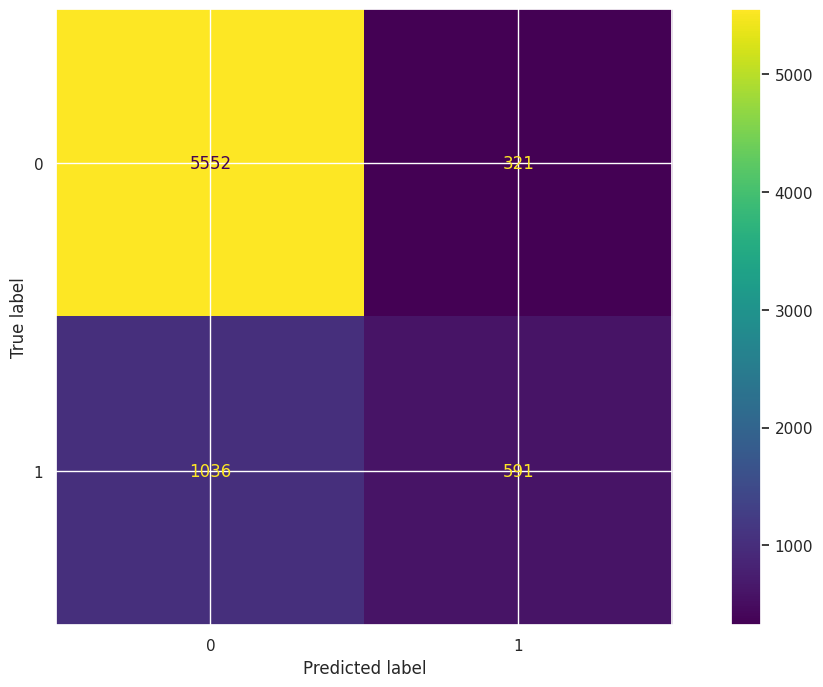

In [17]:
### ConfusionMatrix with LGB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

cm = confusion_matrix(y_val, preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5873
           1       0.65      0.36      0.47      1627

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



### Hyperparameter Tuning LGB.

In [19]:
import optuna
from optuna.visualization import plot_optimization_history

def objective(trial):
    
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0), #The learning rate for boosting.
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000), #The number of boosting rounds.
        'num_leaves': trial.suggest_int('num_leaves', 20, 300), #Maximum number of leaves in a tree.
        'max_depth': trial.suggest_int('max_depth', 3, 15), #Maximum depth of a tree.
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10), #Minimum sum of instance weight needed in a child.
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0), #Fraction of data to be used for fitting the individual base learners.
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0), #Fraction of features used for fitting the individual base learners.
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10), #L1 regularization term on weights.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10), #L2 regularization term on weights.
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 10), #Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), #Minimum number of data needed in a leaf.
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-2, 10) #Balancing of positive and negative weights, typically useful in class-imbalanced datasets.
    }

    
    model = lgb.LGBMClassifier(**param, random_state=42, 
                               boosting_type='gbdt',
                                 metric='auc',
                               objective='binary',
                             n_jobs=1, 
                             verbose=-1,
                              silent=True)
    
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              eval_metric='logloss')
    
    
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy


# Study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

# Best parameters and the corresponding MCC
print("Best hyperparameters:", study.best_params)
print("Best Acccuracy:", study.best_value)

best_model = lgb.LGBMClassifier(**study.best_params, silent=True, random_state=42, boosting_type='gbdt',metric='auc',objective='binary',n_jobs=1, verbose=-1)
best_model.fit(X_train, y_train)
lgm_prediction = best_model.predict(X_val)
print('Accuracy:', accuracy_score(y_val, lgm_prediction))

[I 2024-08-18 03:39:23,216] A new study created in memory with name: no-name-d4806864-6cf8-42ba-9328-365b2beeff0a
[I 2024-08-18 03:39:25,353] Trial 0 finished with value: 0.8106666666666666 and parameters: {'learning_rate': 0.11958416542836836, 'n_estimators': 361, 'num_leaves': 105, 'max_depth': 4, 'min_child_weight': 0.010032083020111108, 'subsample': 0.9500231716738443, 'colsample_bytree': 0.5163909685608927, 'reg_alpha': 2.0507637418273608, 'reg_lambda': 1.888970795992596, 'min_split_gain': 0.04464297995460388, 'min_child_samples': 79, 'scale_pos_weight': 0.4518854179602263}. Best is trial 0 with value: 0.8106666666666666.
[I 2024-08-18 03:39:32,590] Trial 1 finished with value: 0.7674666666666666 and parameters: {'learning_rate': 0.1264333774820053, 'n_estimators': 974, 'num_leaves': 37, 'max_depth': 12, 'min_child_weight': 0.4118619012900272, 'subsample': 0.9018221759538507, 'colsample_bytree': 0.9427992554007647, 'reg_alpha': 0.0019409914203786128, 'reg_lambda': 0.95197715228583

Best hyperparameters: {'learning_rate': 0.04939136980740469, 'n_estimators': 964, 'num_leaves': 228, 'max_depth': 11, 'min_child_weight': 1.4697265532808654, 'subsample': 0.40092846102603774, 'colsample_bytree': 0.7798301557795191, 'reg_alpha': 0.5676671656936567, 'reg_lambda': 0.5586944024120608, 'min_split_gain': 4.640591887605109, 'min_child_samples': 37, 'scale_pos_weight': 0.8884767710036917}
Best Acccuracy: 0.8230666666666666
Accuracy: 0.8230666666666666


In [20]:
plot_optimization_history(study).show()

In [21]:
#{'learning_rate': 0.09643595931243108, 'n_estimators': 393, 'num_leaves': 132, 'max_depth': 6, 'min_child_weight': 0.01390909398098876, 'subsample': 0.4474024331867742, 'colsample_bytree': 0.8200510992673528, 'reg_alpha': 0.34293154104136153, 'reg_lambda': 0.12180592711694652, 'min_split_gain': 6.551917380880274, 'min_child_samples': 77, 'scale_pos_weight': 0.8473208550148504}